# N=100 analysis of LSTM_25-EM_conjcode-ntokens_10-seqlen_13-ntrials_2

### notes
the data analyzed here are from models trained and saved in `model_data/PITask_randstim`

all models were trained with EM=1, ntokens=10 because that is the parametrization in which EM is required

In [37]:
from glob import glob as glob
from itertools import product

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_netL(switch,trep=9,nnets=10):
  netL = []
  for seed in range(nnets):
    fpath = "model_data/PITask_randstim/"
    fpath += "LSTM_25-EM_conjcode-ntokens_10-seqlen_13-ntrials_2-switchmaps_%i-seed_%i-tr_%i00000"%(switch,seed,trep)
    net = PINet(stimdim=10,stsize=25,outdim=10,nmaps=11,seed=seed)
    net.load_state_dict(tr.load(fpath+'-model.pt'))
    net.seed = seed
    netL.append(net)
  return netL

def eval_net(net,gen_data_fn=None,neps=500,return_states=False):
  i,s,a = gen_data_fn()
  exp_len = len(i)
  score = -np.ones([neps,exp_len])
  states = -np.ones([neps,2,exp_len,net.stsize]) # hstate,cstate
  for ep in range(neps):
    # forward prop
    I,S,atarget = gen_data_fn()
    ahat_ulog = net(I,S)
    states[ep] = np.stack([net.hstates,net.cstates])
    trial_score = (maxsoftmax(ahat_ulog) == atarget).numpy()
    score[ep] = trial_score.squeeze()
  ev_acc = score.mean(0)
  if not return_states:
    return ev_acc
  else:
    return ev_acc,states

def eval_netL(netL,ntrials,seqlen,neps=10,return_states=True):
  """ states shape: [nsubs,neps,(c,h),tsteps,stsize]
  """
  nnets = len(netL)
  acc = []
  states = []
  for net in netL:
    task = PurePM(ntokens=10,stimdim=10,seed=net.seed)
    gen_data_fn = lambda: task.gen_ep_data(ntrials,seqlen,switchmaps=1)
    acc_net,states_net = eval_net(net,gen_data_fn,neps,return_states)
    acc.append(acc_net)
    states.append(states_net)
  acc = np.stack(acc)
  states = np.stack(states)
  return acc,states

In [3]:
''' eval and save acc and states of both groups'''
# nnets = 100
# ntrials,seqlen = 6,5
# neps = 200

# accL = []
# statesL = []
# for s in range(2):
#   netL = load_netL(switch=s,nnets=nnets)
#   acc,states = eval_netL(netL,ntrials,seqlen,neps=neps)
#   accL.append(acc)
#   statesL.append(states)

# acc = np.stack(accL)
# states = np.stack(statesL)

# fpath = 'model_data/buckets_eval_data_N100/ntrials_%i-seqlen_%i'%(ntrials,seqlen)
# np.save(fpath+'-acc',acc)
# np.save(fpath+'-states',states)

' eval and save acc and states of both groups'

In [4]:
'''load presaved eval states and acc'''
ntrials,seqlen = 6,5
fpath = 'model_data/buckets_eval_data_N100/ntrials_%i-seqlen_%i'%(ntrials,seqlen)
acc = np.load(fpath+'-acc.npy')
states = np.load(fpath+'-states.npy')

_,nnets,_ = acc.shape
print(states.shape) # (switch,nnets,eps,(h,c),tsteps,stsize)
_,_,neps,_,_,_ = states.shape
print(acc.shape) # (switch,nnets,tsteps)
print()

'''reshape to remove instruction phase, select c or h state, and pull trials dimension'''
# acc
acc = acc.reshape(2,nnets,ntrials,10+seqlen)[:,:,:,10:]
acc0,acc1 = acc
# state
state_class = 'hstate'
states = states[:,:,:,int(state_class=='cstate'),:,:] # switch,nnets,neps,(h,c),tsteps,stsize
states = states.reshape(2,nnets,neps,ntrials,10+seqlen,25)[:,:,:,:,10:,:]

print(states.shape) # (switch,nnets,neps,ntrials,seqlen,stsize)
print(acc.shape) # (switch,nnets,ntrials,seqlen)

(2, 100, 200, 2, 90, 25)
(2, 100, 90)

(2, 100, 200, 6, 5, 25)
(2, 100, 6, 5)


## states RSA

In [5]:
from scipy.spatial import distance
dist_metric = 'correlation'
compute_rdm = lambda M: distance.cdist(M,M,metric=dist_metric)

def get_mean_sub_rdm(states):
  neps,tsteps,stsize = states.shape
  rdm = np.zeros([tsteps,tsteps])
  for ep in range(neps):
    rdm += compute_rdm(states[ep])
  rdm = rdm/neps
  return rdm

def compute_rdms(states):
  """ 
  given cstates [nnets,neps,tsteps,stsize]
  computes TxT rsm for each subj (averaged over neps)
  """
  # init 
  nnets,neps,tsteps,stsize = states.shape
  rsms = -np.ones([nnets,tsteps,tsteps])

  # loop compute RSM
  for sub in range(nnets):
    sub_rsms = -np.ones([neps,tsteps,tsteps])
    sub_state = states[sub]
    for ep in range(neps):
      sub_rsms[ep] = compute_rdm(sub_state[ep])
    rsms[sub] = sub_rsms.mean(0)
  return rsms

In [6]:
''' full rdms '''
_,nnets,neps,ntrials,seqlen,stsize = states.shape
rdms_full = np.ones([2,nnets,ntrials*seqlen,ntrials*seqlen])
states_full = np.concatenate([states[:,:,:,i,:,:] for i in range(ntrials)],-2)

for switch in range(2):
  rdms_full[switch] = compute_rdms(states_full[switch])

rdms_full.shape

(2, 100, 30, 30)

In [7]:
''' comapring two trials '''
tr0,tr1=0,1
states_tr0tr1 = np.concatenate([states[:,:,:,tr0],states[:,:,:,tr1]],axis=-2)
rdms_tr0tr1 = np.ones([2,nnets,2*seqlen,2*seqlen])

for switch in range(2):
  rdms_tr0tr1[switch] = compute_rdms(states_tr0tr1[switch])
  
rdms_tr0tr1.shape

(2, 100, 10, 10)

In [8]:
'''difference in switch - no_switch'''
rdms_diff = rdms_tr0tr1[1] - rdms_tr0tr1[0]
rdms_diff.shape

(100, 10, 10)

Text(0.5, 0.92, 'hstate correlation distance - tr1-tr0')

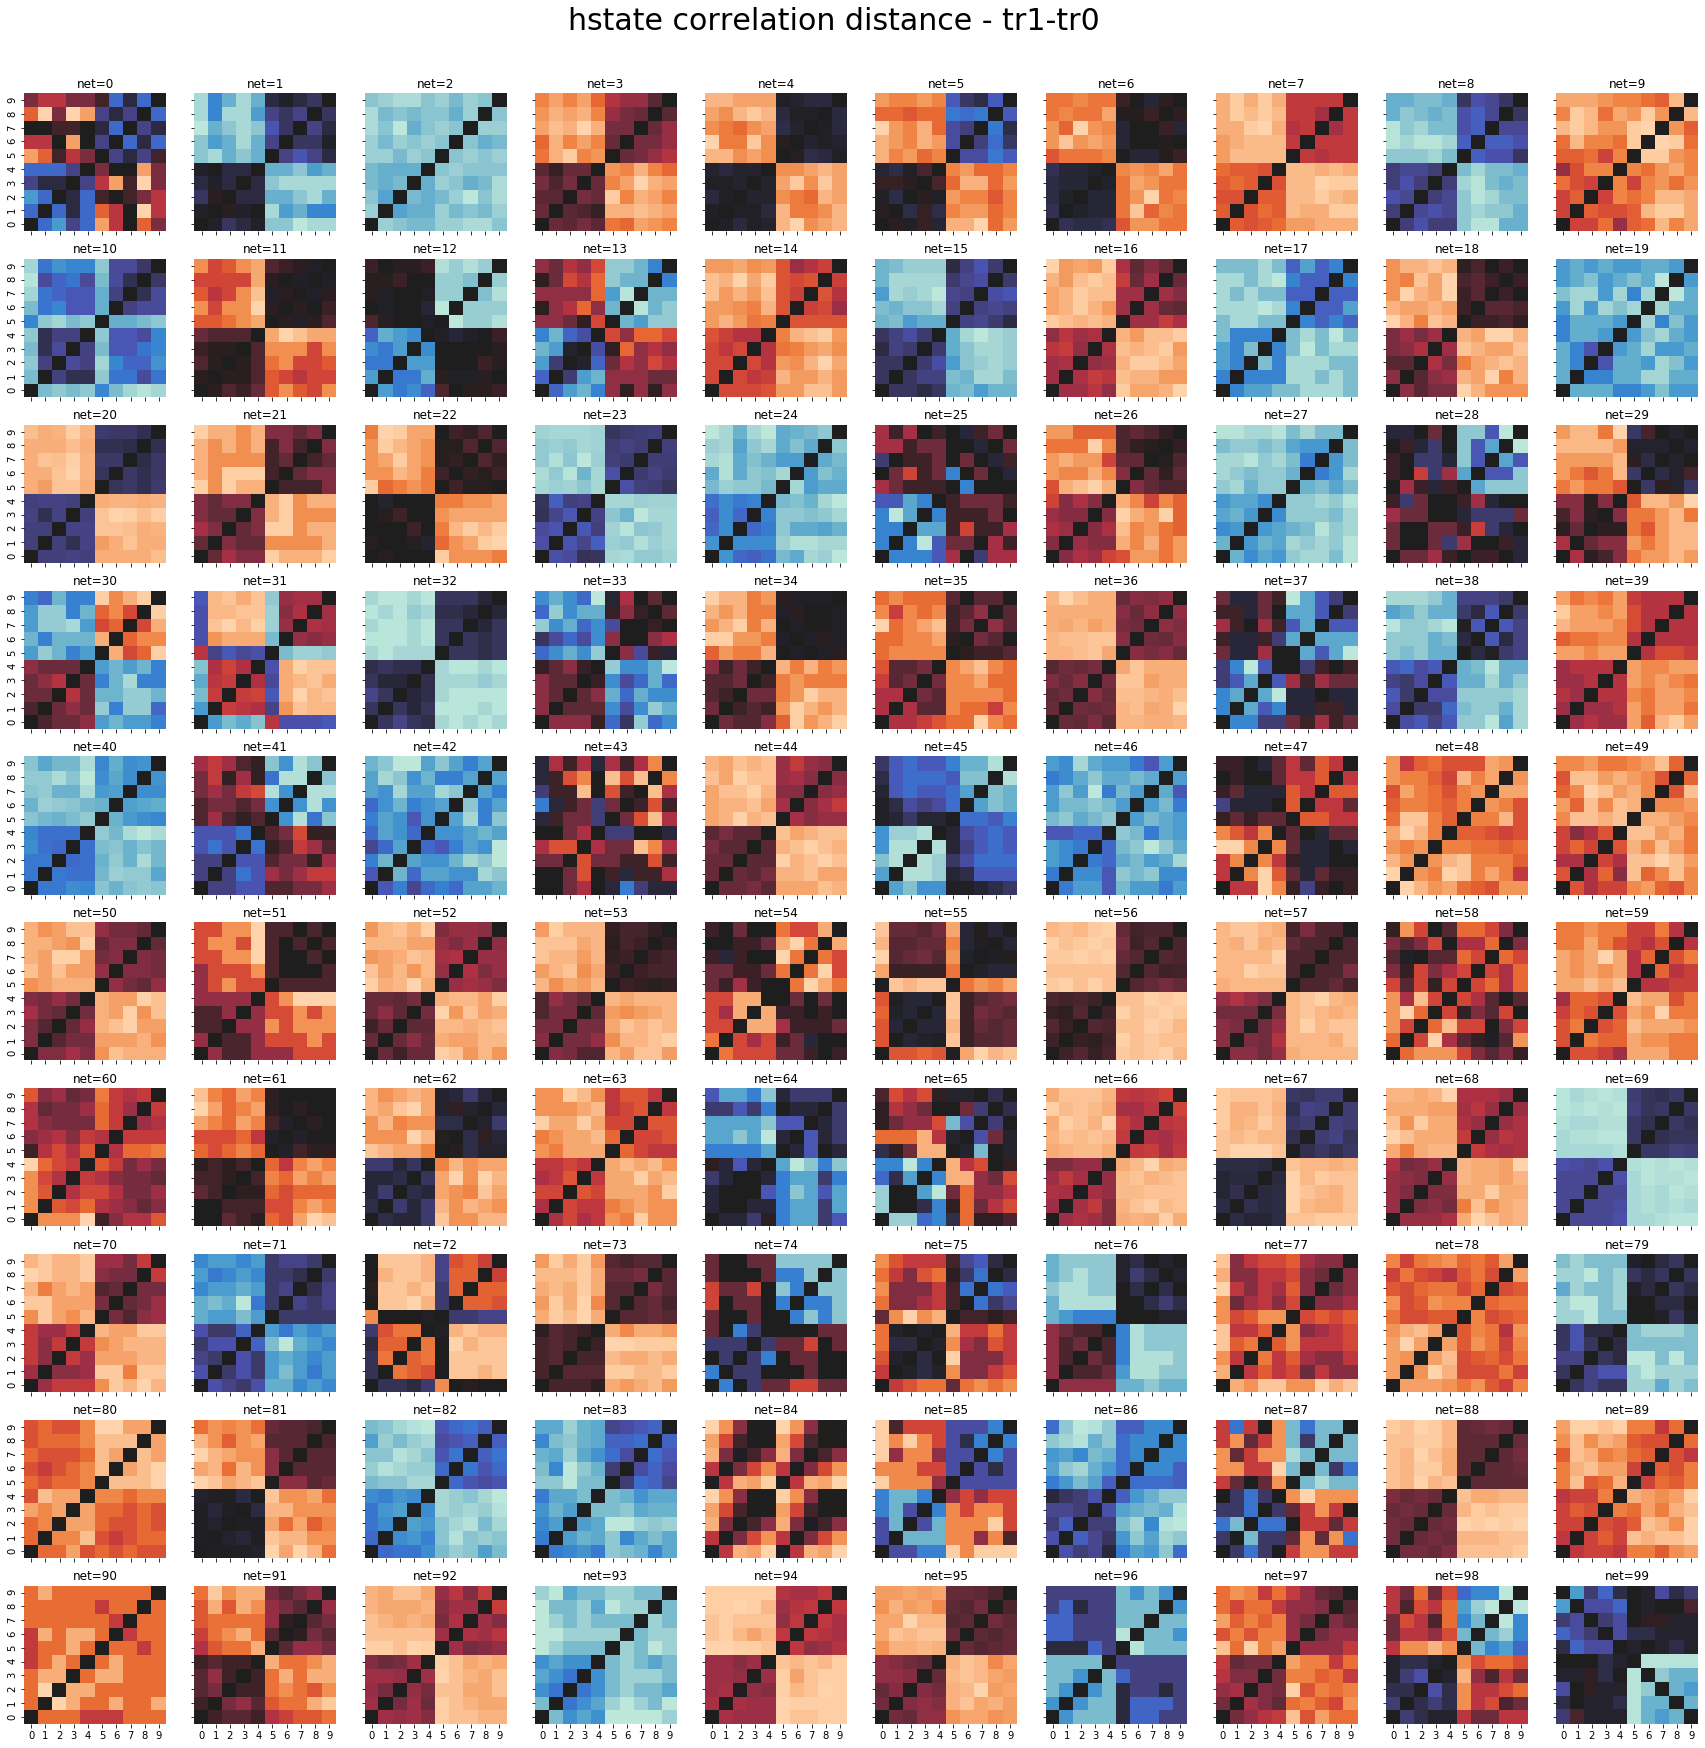

In [10]:
''' subject diff_rdms'''

nnets_plt = 100
plt.close('all')
f=3
fig,axarr = plt.subplots(10,10,figsize=(10*f,10*f),sharex=True,sharey=True);axarr=axarr.reshape(-1)
for net in range(nnets_plt):
  ax = axarr[net]
  ax.set_title('net=%i'%net)
  sns.heatmap(rdms_diff[net].round(2),ax=ax,
              vmin=rdms_diff[net].min(),vmax=rdms_diff[net].max(),
              cbar=False,annot=False,center=0)

plt.suptitle('%s %s distance - tr%i-tr%i'%(state_class,dist_metric,tr1,tr0),fontsize=30,y=.92)
# plt.savefig('figures/buckets_eval_data_N100/mean_sub_rdm_diff-state_class_%s-metric_%s-2trials'%(
#               state_class,dist_metric))

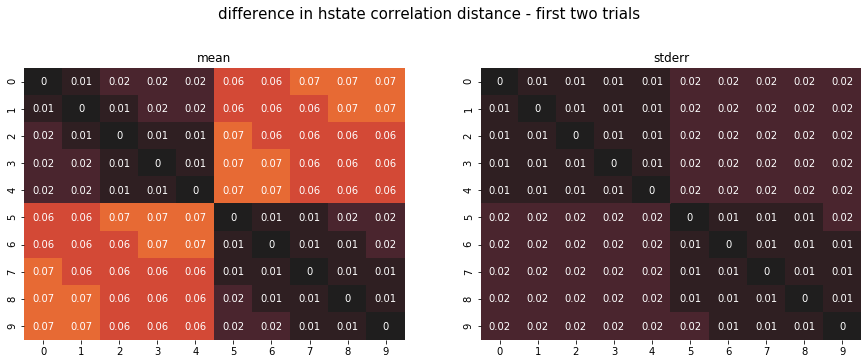

In [12]:
''' group mean and stderr diff_rdms '''
fig,axarr = plt.subplots(1,2,figsize=(15,5))

tL = ['mean','stderr']
dataL = [rdms_diff.mean(0).round(2),
         (rdms_diff.std(0)/np.sqrt(nnets)).round(2)]

for idx in range(2):
  axarr[idx].set_title(tL[idx])
  sns.heatmap(dataL[idx],ax=axarr[idx],
              vmin=-.1,vmax=.1,
              cbar=False,annot=True,center=0)
  
plt.suptitle('difference in %s %s distance - first two trials'%(state_class,dist_metric),fontsize=15,y=1.05)
plt.savefig('figures/buckets_eval_data_N100/group_mean_rdm_diff-state_class_%s-metric_%s-2trials'%(
              state_class,dist_metric))

## separation: mean distance of every state in tr0 to tr1
### mean value of between trial rdm difference

In [11]:
sep = rdms_tr0tr1[:,:,seqlen:,:seqlen].mean((2,3))
sep_diff = sep[1] - sep[0]
# sep_diff2 = rdms_diff[:,seqlen:,:seqlen].mean((1,2,))

Text(0, 0.5, 'pattern separation between tr1 and tr2')

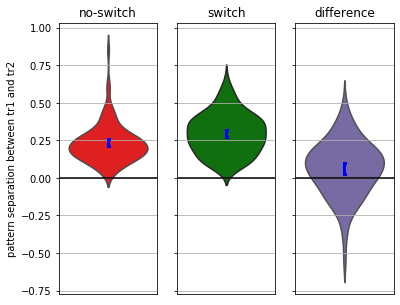

In [13]:
data = np.concatenate([sep,[sep_diff]])

fig,axarr = plt.subplots(1,3,figsize=(6,5),sharey=True)
est = lambda data: np.zeros_like(data)
tL = ['no-switch','switch','difference']
cL = ['red','green',plt.cm.Purples(0.7)]
for idx in range(3):
  ax=axarr[idx]
  sns.violinplot(data[idx],orient='v',inner=None,scale='area',ax=ax,color=cL[idx])
  ax.grid(axis='y')
  ax.set_title(tL[idx])
  sns.barplot(ax=ax,data=data[idx],ci=95,zorder=0,color='white',errwidth=3,capsize=0.01,errcolor='blue')
  ax.set_xticks([])
  ax.axhline(0,c='k')

# plt.suptitle('%s %s distance - first two trials'%(state_class,dist_metric),fontsize=15,y=.93)
axarr[0].set_ylabel('pattern separation between tr1 and tr2')
# plt.savefig('figures/buckets_eval_data_N100/pattern-separation-violin')

## accuracy plot

In [14]:
Macc = acc.mean((1,3)) # mean over nets and time
Sacc = acc.std((1,3))/np.sqrt(nnets)

Text(0.5, 0, 'accuracy')

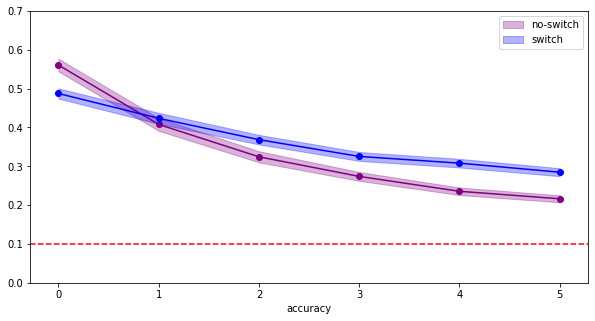

In [15]:
plt.figure(figsize=(10,5))
x_idx = np.arange(ntrials)
cL = ['purple','blue']
labL = ['no-switch','switch']
for i in range(2):
  plt.plot(Macc[i],c=cL[i])
  plt.scatter(range(len(Macc[i])),Macc[i],c=cL[i])
  plt.fill_between(x_idx,Macc[i]-Sacc[i],Macc[i]+Sacc[i],alpha=.3,color=cL[i],label=labL[i])
plt.legend()
plt.axhline(0.1,c='red',ls='--')
plt.ylim(0,.7)
plt.xlabel('trial')
plt.xlabel('accuracy')
# plt.savefig('figures/buckets_eval_data_N100/trial accuracy')

Text(0, 0.5, 'accuracy difference')

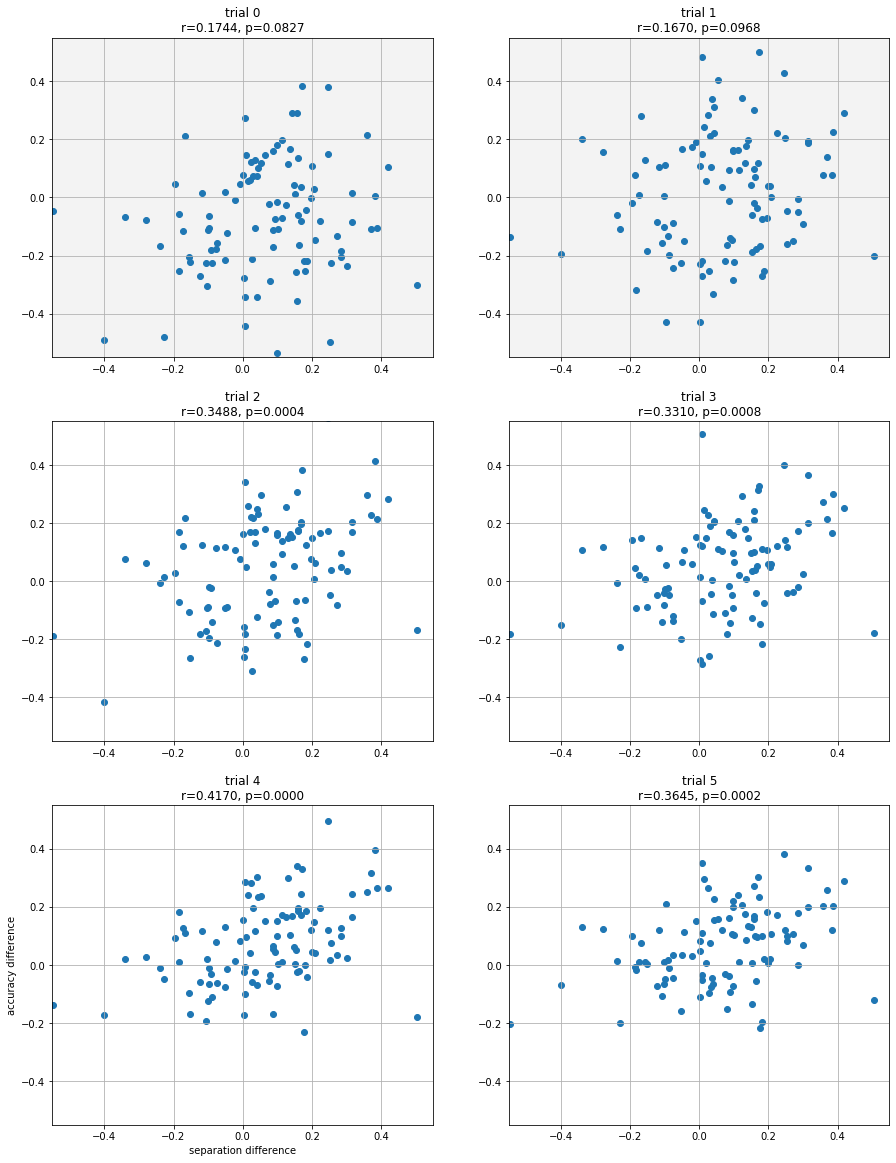

In [16]:
''' scatter accuracy against separation'''

from scipy.stats import pearsonr

sep_diff = sep[1] - sep[0]
acc_diff = (acc[1]-acc[0]).mean(-1)

fig,axarr = plt.subplots(int(ntrials/2),2,figsize=(15,20));axarr=axarr.reshape(-1)
for trial in range(ntrials):
  r,p = pearsonr(acc_diff[:,trialr],sep_diff)
  ax = axarr[trial]
  ax.set_title('trial %i\nr=%.4f, p=%.4f'%(trial,r,p))
  ax.scatter(sep_diff,acc_diff[:,trial])
  ax.set_ylim(-.55,.55)
  ax.set_xlim(-.55,.55)
  ax.grid(True)
  
for idx in range(2):
  axarr[idx].set_facecolor(plt.cm.Greys(0.1))
axarr[4].set_xlabel('separation difference')
axarr[4].set_ylabel('accuracy difference')
# plt.savefig('figures/buckets_eval_data_N100/scatter-separation_by_accuracy')

# pure LSTM controls

In [23]:
def mov_avg(arr,wind):
  M = -np.ones(len(arr)-wind)
  for idx in range(len(M)):
    M[idx] = arr[idx:idx+wind].mean()
  return M

In [46]:
''' load pure LSTM models'''

def load_netL_lstms(nnets)
  fdir = "model_data/PITask_randstim/"
  netL = []
  for seed in range(1,nnets+1):
    net = PINet(stimdim=10,stsize=25,outdim=10,nmaps=11,seed=seed)
    net.seed = seed
    fpath = "LSTM_25-EM_0-ntokens_10-seqlen_13-ntrials_2-switchmaps_%i-seed_%i-tr_900000" %(seed,seed)
    net.load_state_dict(tr.load(fdir+fpath+'-model.pt'))
    netL.append(net)
  return netL

In [56]:
''' eval and save acc and states of both groups'''
# nnets = 99
# ntrials,seqlen = 6,5
# neps = 200

# accL = []
# statesL = []

# netL = load_netL_lstms(nnets)
# acc,states = eval_netL(netL,ntrials,seqlen,neps=neps)
# accL.append(acc)
# statesL.append(states)

# acc = np.stack(accL)
# states = np.stack(statesL)

# fpath = 'model_data/buckets_eval_data_N100/ntrials_%i-seqlen_%i-pure_lstm'%(ntrials,seqlen)
# np.save(fpath+'-acc',acc)
# np.save(fpath+'-states',states)

In [82]:
''' load acc '''
fpath = 'model_data/buckets_eval_data_N100/ntrials_%i-seqlen_%i-pure_lstm'%(ntrials,seqlen)
acc = np.load(fpath+'-acc.npy')[0]
acc = acc.reshape(nnets,ntrials,10+seqlen)[:,:,10:]

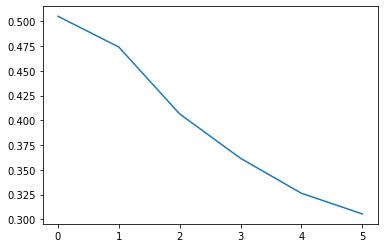

In [85]:

plt.plot(acc.mean((0,2)))

In [71]:
acc.reshape(nnets,seqlen+10).shape

ValueError: cannot reshape array of size 8910 into shape (10,15)

In [70]:
90/5

18.0

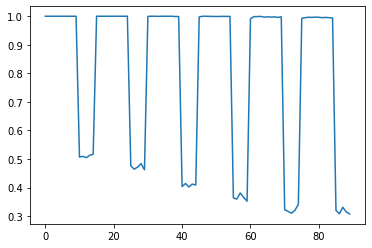

In [53]:
plt.plot(acc.mean(0))